# Import packages

In [ ]:
# # If needed, install the following packages:

# !pip install azure-ai-documentintelligence==1.0.0b1
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install tensorflow
# !pip install sklearn
# !pip install scipy

In [2]:
from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.core.credentials import AzureKeyCredential
import numpy as np 
import pandas as pd 
import random
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import cv2
import re
import io
import copy
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import layers, models
from sklearn.metrics.pairwise import euclidean_distances as L2, cosine_similarity as cs
from collections import Counter
from scipy.spatial.distance import cdist

2025-02-05 14:40:55.997682: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-05 14:40:57.191480: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-05 14:40:58.293695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738766459.054921  247859 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738766459.285549  247859 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-05 14:41:01.622297: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## Choose engine

In [3]:
ENGINE_IS_TPU = False

In [4]:
class StrategyDummy:
    class DummyContext:
        def __enter__(self):
            pass
        def __exit__(self, exc_type, exc_value, traceback):
            pass
    def scope(self):
        return self.DummyContext()
        
if ENGINE_IS_TPU: # This is the TPU initialization
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print("All devices: ", tf.config.list_logical_devices('TPU'))
    strategy = tf.distribute.TPUStrategy(tpu)
else: # Dummy strategy
    strategy = StrategyDummy()

# Load Dataset

The dataset should be structured as follows: 
each document template should have its own folder, and within each folder, all documents in ".jpg" format that match that template must be stored.

In [5]:
DATASET_PATH = '/home/dut-ftp-user/Documents/miguel/JupyterWorkspace/Similarity Classifier Siamese Network/All Templates Dataset v9/All Templates/'

## Ensure All Image Names Are Unique
Quickly check that no images have the same filename. If any duplicates exist, rename them to avoid issues.

In [6]:
images_names = []
for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    images_names.extend(filenames)
counter = Counter(images_names)
repeated_image_names = [img_name for img_name, count in counter.items() if count > 1]
print('Repeated image names(please fix):', repeated_image_names)

Repeated image names(please fix): []


## Divide the templates for training set and test set

In order to ensure the independence of training and test set, the split will be performed at a template level, where some templates will be assigned to the training set and the rest to the test set.

In [7]:
# Set the train and test split by percetage templates to have in train set
TRAIN_TEST_RATIO = 0.8

In [8]:
templates_names = [dir for dir in os.listdir(DATASET_PATH)]
random.shuffle(templates_names)
train_templates = templates_names[:int(len(templates_names)*TRAIN_TEST_RATIO)]
test_templates = templates_names[int(len(templates_names)*TRAIN_TEST_RATIO):]

In [43]:
# train_templates = list(train['label'].unique())
# test_templates = list(test['label'].unique())

## Generate Triplets

The input for the Siamese Network are triplets, consisting of an anchor image, a positive image(same template as anchor) and negative image(different template than anchor).
The model learns by comparing the distance between the anchor and the positive image versus the anchor and the negative image.

To optimize learning, the goal is to create the best possible triplets. Initially, triplets are generated randomly. However, to improve training, we also use previous model runs to measure image distances and include hard samples—cases where the anchor and negative image are more visually similar, making the learning process more effective. (They will only be added to the training set)

The previous calculated distances can be obtained in the section: Get all documents distance from Confusion Matrix output. If they are not available, the option to not use them can be set with the variable USE_HARD_SAMPLES_FROM_PREVIOUS_DISTANCES.


**Random Triplets Generation:** 
<br>
To generate the random triplets, all the combinations of positive combinations of images of the same template will be calculated, then, with LIMIT_OF_TRIPLETS_PER_TEMPLATE, we can limit the number of positive pairs we can have for each template in order to not have an imbalanced dataset.

**Semi-Hard Triplets Generation:**
<br>
It will be needed to define the path of the previous distances in ALL_DOCS_DISTANCES_FROM_PREVIOUS_MODEL_PATH.
In that file, we will have the distance of each possible pair of the dataset, to keep the ones that are the hardest, we will define 2 thresholds:
- POS_THRESHOLD: If the pair of images belong to the same template and the distance is above this number, it will be considered a hard pair and added to the dataset.
- NEG_THRESHOLD: If the pair of images belong to different templates and the distance is below this number, it will be considered a hard pair and added to the dataset.
- MARGIN: minimum difference between positive pairs and negative pairs
- MAX_SEMI_HARD_TRIPLETS_PER_TEMPLATE: maximum number of semi-hard triplets to have per every template


**Warning:** The creation of semi-hard triplets is computationally expensive and may take a long time.

In [48]:
LIMIT_OF_TRIPLETS_PER_TEMPLATE = 20 
USE_HARD_SAMPLES_FROM_PREVIOUS_DISTANCES = True
ALL_DOCS_DISTANCES_FROM_PREVIOUS_MODEL_PATH = '/home/dut-ftp-user/Documents/miguel/JupyterWorkspace/Similarity Classifier Siamese Network/all_docs_distances_iterative.csv'
POS_THRESHOLD = 0.4
NEG_THRESHOLD = 0.9
MARGIN = 1
MAX_SEMI_HARD_TRIPLETS_PER_TEMPLATE = 50

In [12]:
def get_negative_sample(dataset_path, options_neg_templates, doc_name):
    neg_label = options_neg_templates[random.randint(0, len(options_neg_templates)-1)]
    neg_files = os.listdir(os.path.join(dataset_path, neg_label))
    neg = os.path.basename(neg_files[random.randint(0, len(neg_files)-1)])
    return neg, neg_label

In [13]:
def create_random_triplets(dataset_path, allowed_templates, limit_per_template=999999):
    triplets = []
    anchor_neg_list = []

    for dirpath, dirnames, filenames in os.walk(dataset_path):
        if os.path.basename(dirpath) in allowed_templates:
            all_combinations = []
            for i in range(len(filenames)):  # Get all possible combinations
                for j in range(i+1, len(filenames)):
                    all_combinations.append((filenames[i], filenames[j]))
            random.shuffle(all_combinations)
            for k in range(min(limit_per_template, len(all_combinations))):
                triplets.append({'anchor': all_combinations[k][0], 'pos': all_combinations[k][1], 'label': os.path.basename(dirpath)}) 
    
    for i in range(len(triplets)):
        options_neg_templates = copy.deepcopy(allowed_templates)
        options_neg_templates.remove(triplets[i]['label'])
        triplets[i]['neg'], triplets[i]['neg_label'] = get_negative_sample(dataset_path, options_neg_templates, triplets[i]['anchor'])
        anchor_neg_list.append(set((triplets[i]['anchor'], triplets[i]['neg'])))
            
    return triplets

In [44]:
def generate_triplets_from_previous_distances(allowed_templates, all_docs_previous_distances, pos_threshold=POS_THRESHOLD, neg_threshold=NEG_THRESHOLD, margin=MARGIN, max_semi_hard_triplets_per_template=MAX_SEMI_HARD_TRIPLETS_PER_TEMPLATE):
    # Filter by allowed templates
    filtered_all_docs_previous_distances = all_docs_previous_distances[(all_docs_previous_distances['template_doc1'].isin(allowed_templates)) & (all_docs_previous_distances['template_doc2'].isin(allowed_templates))]
    # Divide by same template and different template
    df_same_template = filtered_all_docs_previous_distances[filtered_all_docs_previous_distances['template_doc1'] == filtered_all_docs_previous_distances['template_doc2']].reset_index(drop=True)
    df_diff_template = filtered_all_docs_previous_distances[filtered_all_docs_previous_distances['template_doc1'] != filtered_all_docs_previous_distances['template_doc2']].reset_index(drop=True)
    # Sort by distances
    df_same_template = df_same_template.sort_values(by='distance', ascending=False).reset_index(drop=True)
    df_diff_template = df_diff_template.sort_values(by='distance', ascending=True).reset_index(drop=True)
    #Filter by thresholds
    df_same_template = df_same_template[df_same_template['distance'] > pos_threshold].reset_index(drop=True)
    df_diff_template = df_diff_template[df_diff_template['distance'] < neg_threshold].reset_index(drop=True)
    
    #Randomize df_same_template to mix anchor and positive
    mask = [random.choice([True, False]) for _ in range(len(df_same_template))]
    df_same_template.loc[mask, ['doc_name1', 'doc_name2']] = (df_same_template.loc[mask, ['doc_name2', 'doc_name1']].values)
    
    # Create triplets
    triplets = []
    neg_tuples = []
    rows_per_template = {}
    for i, row in df_same_template.iterrows():
        if i % 500 == 0:
            print(f'{i}/{df_same_template.shape[0]}')
        if row['template_doc1'] in rows_per_template and rows_per_template[row['template_doc1']] > max_semi_hard_triplets_per_template: # Limit the number of triplets per template
            continue
        df_dist_anchor_neg1 = df_diff_template[df_diff_template['doc_name1'] == row['doc_name1']]
        df_dist_anchor_neg2 = df_diff_template[df_diff_template['doc_name2'] == row['doc_name1']]
        df_dist_anchor_neg2['doc_name2'] = df_dist_anchor_neg2['doc_name1']
        df_dist_anchor_neg2['template_doc2'] = df_dist_anchor_neg2['template_doc1']
        df_dist_anchor_neg2['doc_name1'] = row['doc_name1']
        df_dist_anchor_neg2['template_doc1'] = row['template_doc1']
        df_dist_anchor_neg = pd.concat([df_dist_anchor_neg1, df_dist_anchor_neg2])

        semi_hard_negs = df_dist_anchor_neg[(row['distance']**2 < df_dist_anchor_neg['distance']**2) & (df_dist_anchor_neg['distance']**2 < row['distance']**2 + margin)] # formula to obtain semi-hard negatives
        
        new_triplet = {}
        for j, semi_hard_row in semi_hard_negs.iterrows():
            if (semi_hard_row['doc_name1'], semi_hard_row['doc_name2']) not in neg_tuples and (semi_hard_row['doc_name2'], semi_hard_row['doc_name1']) not in neg_tuples:
                new_triplet = {'anchor': row['doc_name1'], 'pos': row['doc_name2'], 'label': row['template_doc1'], 'neg': semi_hard_row['doc_name2'], 'neg_label': semi_hard_row['template_doc2']}
                break

        if not new_triplet:
            for j, diff_tem  in df_dist_anchor_neg.iterrows():
                if (diff_tem['doc_name1'], diff_tem['doc_name2']) not in neg_tuples and (diff_tem['doc_name2'], diff_tem['doc_name1']) not in neg_tuples:
                    new_triplet = {'anchor': row['doc_name1'], 'pos': row['doc_name2'], 'label': row['template_doc1'], 'neg': diff_tem['doc_name2'], 'neg_label': diff_tem['template_doc2']} 
                    break
        if new_triplet:
            triplets.append(new_triplet)
            neg_tuples.append((new_triplet['anchor'], new_triplet['neg']))
            if new_triplet['label'] in rows_per_template:
                rows_per_template[new_triplet['label']] += 1
            else:
                rows_per_template[new_triplet['label']] = 1

    return pd.DataFrame(triplets)

In [114]:
# Generate random triplets
random_triplets_train = pd.DataFrame(create_random_triplets(DATASET_PATH, train_templates, limit_per_template=LIMIT_OF_TRIPLETS_PER_TEMPLATE))
random_triplets_test = pd.DataFrame(create_random_triplets(DATASET_PATH, test_templates, limit_per_template=LIMIT_OF_TRIPLETS_PER_TEMPLATE))

# Add hard triplets
if USE_HARD_SAMPLES_FROM_PREVIOUS_DISTANCES:
    all_docs_previous_distances = pd.read_csv(ALL_DOCS_DISTANCES_FROM_PREVIOUS_MODEL_PATH)
    hard_triplets_train = generate_triplets_from_previous_distances(train_templates, all_docs_previous_distances)
    train = pd.concat([random_triplets_train, hard_triplets_train]).sample(frac = 1).reset_index(drop=True)
else:
    train = pd.concat([random_triplets_train]).sample(frac = 1).reset_index(drop=True)

test = pd.concat([random_triplets_test]).sample(frac = 1).reset_index(drop=True)
data = pd.concat([train, test]).reset_index(drop=True)

/tmp/ipykernel_47591/3634644694.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dist_anchor_neg2['doc_name2'] = df_dist_anchor_neg2['doc_name1']
/tmp/ipykernel_47591/3634644694.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dist_anchor_neg2['template_doc2'] = df_dist_anchor_neg2['template_doc1']
/tmp/ipykernel_47591/3634644694.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [67]:
train.shape

(7929, 5)

In [68]:
data

,anchor,pos,label,neg,neg_label
0,25457_20241003_99995272_page_1.jpg,25455_20241003_99995272_page_1.jpg,rarc,03012023_13223643CENF690462_202301031037_page_...,Alsco
1,Separate-RoundRock-31893460190.jpg,Separate-RoundRock-3713111101.jpg,Separate-RoundRock,INI0100630385BW1TI2122115262-1_page_4.jpg,India_48_2
2,MCL-Woodlands-07237601.jpg,MCL-Woodlands-07237401.jpg,MCL-Woodlands,MLCR-SanAngelo-3254335784.jpg,MLCR-SanAngelo
3,23012023_09131520Invoice INV-13528.jpg,17092021162052.jpg,THE LXANDA GROUP PTY LTD,Factura-Vodafone JULY_page_3.jpg,Vodafone Romania_2
4,10012023_0801351820406490.jpg,10012023_0801264620392065.jpg,Rentokil Initial Pty Ltd,Invoice 873280223 11th May 2022_page_1.jpg,UK Vodafone_1
...,...,...,...,...,...
9670,23072_20240907_99995270_page_1.jpg,26176_20241009_99995270_page_1.jpg,two_squares,18__TO_121178_20_USPKG_012921.pdf.jpg,class43
9671,1363920.jpg,1325832.jpg,06178,document-page-3829197493-2.jpg,class22
9672,09209765267 (4)_page_4.jpg,09209765267 (6)_page_4.jpg,Smart_2,INI0100633875Invoice_SS-21-22-Feb-79A.jpg,India_47
9673,83__TO_121205_18_USPKG_020121.pdf.jpg,85__TO_121205_18_USPKG_020121.pdf.jpg,class35,50__TO_121178_20_USPKG_012921.pdf.jpg,class43


## Save triplets (for future use)

In [8]:
# TRAIN_TRIPLETS_PATH = 'train_triplets.csv'
# TEST_TRIPLETS_PATH = 'test_triplets.csv'

In [9]:
# train.to_csv(TRAIN_TRIPLETS_PATH, index=False)
# test.to_csv(TEST_TRIPLETS_PATH, index=False)

## Load triplets

In [5]:
TRAIN_TRIPLETS_PATH = 'train_triplets.csv'
TEST_TRIPLETS_PATH = 'test_triplets.csv'

In [6]:
train = pd.read_csv(TRAIN_TRIPLETS_PATH)
test = pd.read_csv(TEST_TRIPLETS_PATH)
data = pd.concat([train, test])

## Copy images to ease accessibility

To ease the access of the images for the preprocessing and visualization, this code will copy all the images present in the dataset to the desired location.

In [15]:
IMAGES_PATH = '/home/dut-ftp-user/Documents/miguel/JupyterWorkspace/Similarity Classifier Siamese Network/All Templates Dataset v9/images'

In [8]:
# if not os.path.exists(IMAGES_PATH):
#     os.mkdir(IMAGES_PATH)
# for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
#     for filename in filenames:
#         os.system(f'cp "{os.path.join(dirpath, filename)}" "{os.path.join(IMAGES_PATH, filename)}"')

# Preprocessing

Before the images are sent to the model for training, they need to be preprocessed so that the model can learn and predict better.

## Extract OCR

The OCR of the image needs to be extracted, here we use Azure OCR for this extraction. The OCR will be saved in a json file per image in the desired folder.

In [54]:
# Path were OCR will be stored for future use
IMAGES_OCR_PATH = '/home/dut-ftp-user/Documents/miguel/JupyterWorkspace/Similarity Classifier Siamese Network/All Templates Dataset v9/images_ocr' 
if not os.path.exists(IMAGES_OCR_PATH):
    os.mkdir(IMAGES_OCR_PATH)

# Azure OCR configuration
AZURE_DI_ENDPOINT = 'https://doc-intelligence-smartops-t102.cognitiveservices.azure.com/'
AZURE_DI_SUBSCRIPTION_KEY = '7319cf168ac1453b8185c4c9cbf49f6d'
AZURE_DI_DEFAULT_CONFIG = {} 
AZURE_DI_CONFIG_READING_ORDER = 'readingOrder'
AZURE_DI_MODEL_ID = 'prebuilt-read'
AZURE_DI_CONTENT_TYPE = 'application/octet-stream'

In [51]:
def do_azure_di_ocr(client, image: np.ndarray):
    _, im_buf_arr = cv2.imencode('.jpg', image)
    img = io.BytesIO(im_buf_arr)
    config = {key: value for key, value in AZURE_DI_DEFAULT_CONFIG.items() if (key != AZURE_DI_CONFIG_READING_ORDER)}
    poller = client.begin_analyze_document(
        model_id=AZURE_DI_MODEL_ID,
        analyze_request=img,
        content_type=AZURE_DI_CONTENT_TYPE,
        **config
    )
    return poller.result()

In [52]:
def get_bounding_box(bb_list):
    bb_x = bb_list[::2]
    bb_y = bb_list[1::2]
    return [int(min(bb_x)), int(min(bb_y)), int(max(bb_x)), int(max(bb_y))]

In [53]:
def get_image_words(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    img_ocr = do_azure_di_ocr(azure_di_client, img)
    img_words = []
    for word in img_ocr['pages'][0]['words']:
        img_words.append({'bbox': get_bounding_box(bb_list=word.polygon),
                          'text': word.content})
    return img_words

In [ ]:
# Extract and save OCR
azure_di_client = DocumentIntelligenceClient(endpoint=AZURE_DI_ENDPOINT, credential=AzureKeyCredential(AZURE_DI_SUBSCRIPTION_KEY))
for i, image_name in enumerate(os.listdir(IMAGES_PATH)):
    if image_name.replace('.jpg', '.json') not in os.listdir(IMAGES_OCR_PATH):
        print(f'{i+1}/{len(os.listdir(IMAGES_PATH))}')
        img_words = get_image_words(os.path.join(IMAGES_PATH, image_name))
        with open(os.path.join(IMAGES_OCR_PATH, image_name.replace('.jpg', '.json')), 'w') as f:
            json.dump(img_words, f)

### Set OCR from dataset

If the OCR extraction was already performed, the contianing folder can be loaded here:

In [43]:
IMAGES_OCR_PATH = '/home/dut-ftp-user/Documents/miguel/JupyterWorkspace/Similarity Classifier Siamese Network/All Templates Dataset v9/images_ocr'

## Preprocess Images

Image transformations will be performed here. The whole dataset will be processed and the processed images will be stored in the set folder.

In [44]:
PREPROCESSED_IMAGES_PATH = '//home/dut-ftp-user/Documents/miguel/JupyterWorkspace/Similarity Classifier Siamese Network/All Templates Dataset v9/preprocessed_images'
if not os.path.exists(PREPROCESSED_IMAGES_PATH):
    os.mkdir(PREPROCESSED_IMAGES_PATH)

In [45]:
def print_2_images_from_array(img1, img2, text_img1='Image 1', text_img2='Image 2'):
    f, axarr = plt.subplots(1,2,figsize=(20, 8))
    axarr[0].imshow(img1)
    axarr[0].title.set_text(text_img1)
    axarr[1].imshow(img2)
    axarr[1].title.set_text(text_img2)
    plt.show()

In [46]:
def print_3_images_from_array(img1, img2, img3, 
                              text_img1='Image 1', 
                              text_img2='Image 2', 
                              text_img3='Image 3'):
    f, axarr = plt.subplots(1, 3, figsize=(30, 10))
    axarr[0].imshow(img1)
    axarr[0].title.set_text(text_img1)
    axarr[1].imshow(img2)
    axarr[1].title.set_text(text_img2)
    axarr[2].imshow(img3)
    axarr[2].title.set_text(text_img3)
    plt.show()

In [47]:
def preprocess_with_white_padding(img):
    height, width = img.shape[0], img.shape[1]
    # Calculate padding
    if height > width:
        pad_width = (height - width) // 2
        pad_height = 0
        paddings = [[0, 0], [pad_width, pad_width], [0, 0]]
    elif width > height:
        pad_height = (width - height)
        pad_width = 0
        paddings = [[0, pad_height], [0, 0], [0, 0]]
    else:  
        return img
    # Pad the image with white pixels using constant value 255
    padded_img = tf.pad(img, paddings, constant_values=255)
    
    return padded_img

In [48]:
def get_img_max_coords_from_ocr(image, image_ocr):
    x_min, y_min = image.shape[1], image.shape[0]
    x_max, y_max = 0, 0
    for word in image_ocr:
        x_min = min(word['bbox'][0], x_min)
        y_min = min(word['bbox'][1], y_min)
        x_max = max(word['bbox'][2], x_max)
        y_max = max(word['bbox'][3], y_max)
    return x_min, y_min, x_max, y_max

In [49]:
def crop_white_border(image, image_ocr):
    min_contour_area = (image.shape[0] * image.shape[1]) / 2000
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert the image to grayscale
    _, thresh = cv2.threshold(gray, 245, 255, cv2.THRESH_BINARY_INV) # Threshold the image to separate foreground and background
    thresh = thresh.astype(np.uint8) # Ensure the thresholded image is 8-bit unsigned integer
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # Find contours of non-white regions
    # Find the bounding box of the combined region
    x_min, y_min, x_max, y_max = get_img_max_coords_from_ocr(image, image_ocr)
    for contour in contours:
        if cv2.contourArea(contour) > min_contour_area:
            x, y, w, h = cv2.boundingRect(contour)
            # cv2.rectangle(image, (x, y), (x+w, y+h), color=(0,0,0), thickness=5)
            x_min = min(x, x_min)
            y_min = min(y, y_min)
            x_max = max(x + w, x_max)
            y_max = max(y + h, y_max)
    # Crop the image based on the combined bounding box
    cropped_image = image[y_min:y_max, x_min:x_max] 
    # Move cropped area to the middle of the image
    original_height, original_width = image.shape[:2]
    cropped_height, cropped_width = cropped_image.shape[:2]
    padded_image = np.ones((original_height, original_width, image.shape[2]), dtype=image.dtype) * 255
    horizontal_offset = (original_width - cropped_width) // 2
    padded_image[:cropped_height, horizontal_offset:horizontal_offset + cropped_width] = cropped_image
    return padded_image

In [50]:
def thicken_borders(image, color=(0, 0, 0), dilate_iterations=2, canny_threshold1=75, canny_threshold2=150):
    image = image.numpy().astype(np.uint8)  # Convert to uint8
    thickness = max(int(round(((image.shape[0] + image.shape[1]) / 2) / 400, 0)), 0)
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply Gaussian blur to reduce noise
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    # Detect edges using Canny
    edges = cv2.Canny(gray, canny_threshold1, canny_threshold2, L2gradient=True)
    # Dilate the edges to thicken them
    kernel = np.ones((thickness, thickness), np.uint8)
    thickened_edges = cv2.dilate(edges, kernel, iterations=dilate_iterations)
    # Create a mask for the thickened edges
    thicken_edge_mask = thickened_edges > 0
    # Create a copy of the original image to modify
    result = image.copy()
    # Overlay the thickened borders in the specified color
    result[thicken_edge_mask] = color        
    return result

In [36]:
def highlight_word(img, word, color):
    pt1 = (word['bbox'][0], word['bbox'][1])
    pt2 = (word['bbox'][2], word['bbox'][3])
    cv2.rectangle(img, pt1, pt2, color, thickness=-1)

def highlight_text(img, img_ocr):
    for word in img_ocr:
        if re.findall('^[\$€₹]*[0-9,\-]+\.*[0-9]+[\$€₹]*$', word['text']): # Highlight numbers
            highlight_word(img, word, color=(255, 0, 0))
        elif re.findall('[0-9]{1,2}[/-][0-9]{1,2}[/-][0-9]{2,4}', word['text']): # Highlight dates
            highlight_word(img, word, color=(0, 255, 0))
    return img

In [38]:
def doc_preprocessing(img, img_ocr):
    img = highlight_text(img, img_ocr)
    img = crop_white_border(img, img_ocr)
    img = preprocess_with_white_padding(img) # add white padding to keep proportions
    img = thicken_borders(img)
    return img

In [39]:
def preprocess_image(image_path, img_ocr_path):
    img = load_img(image_path)
    img = img_to_array(img)
    with open(img_ocr_path) as f:
        img_ocr = json.load(f)
    img_pp = doc_preprocessing(img, img_ocr)
    return img_pp

### Test image preprocessing

24691_20240926_99995270_page_1.jpg (2200, 1700, 3)


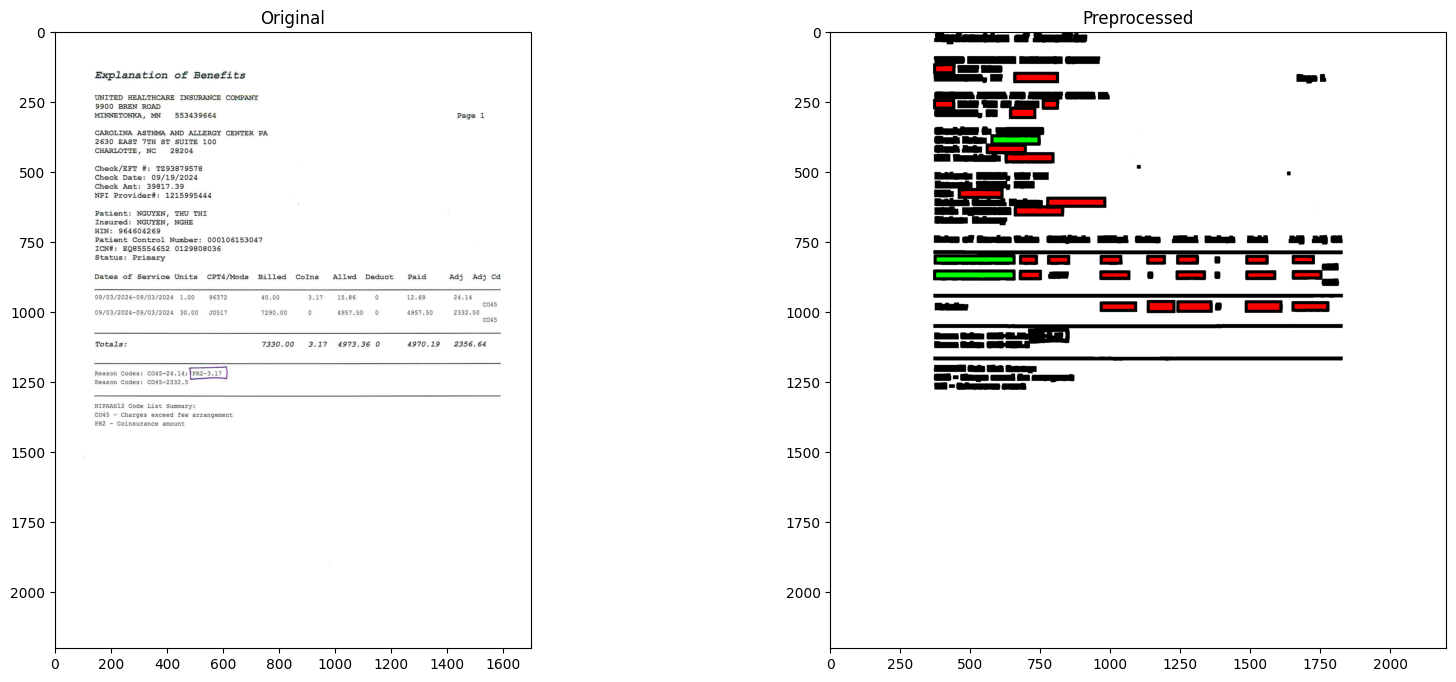

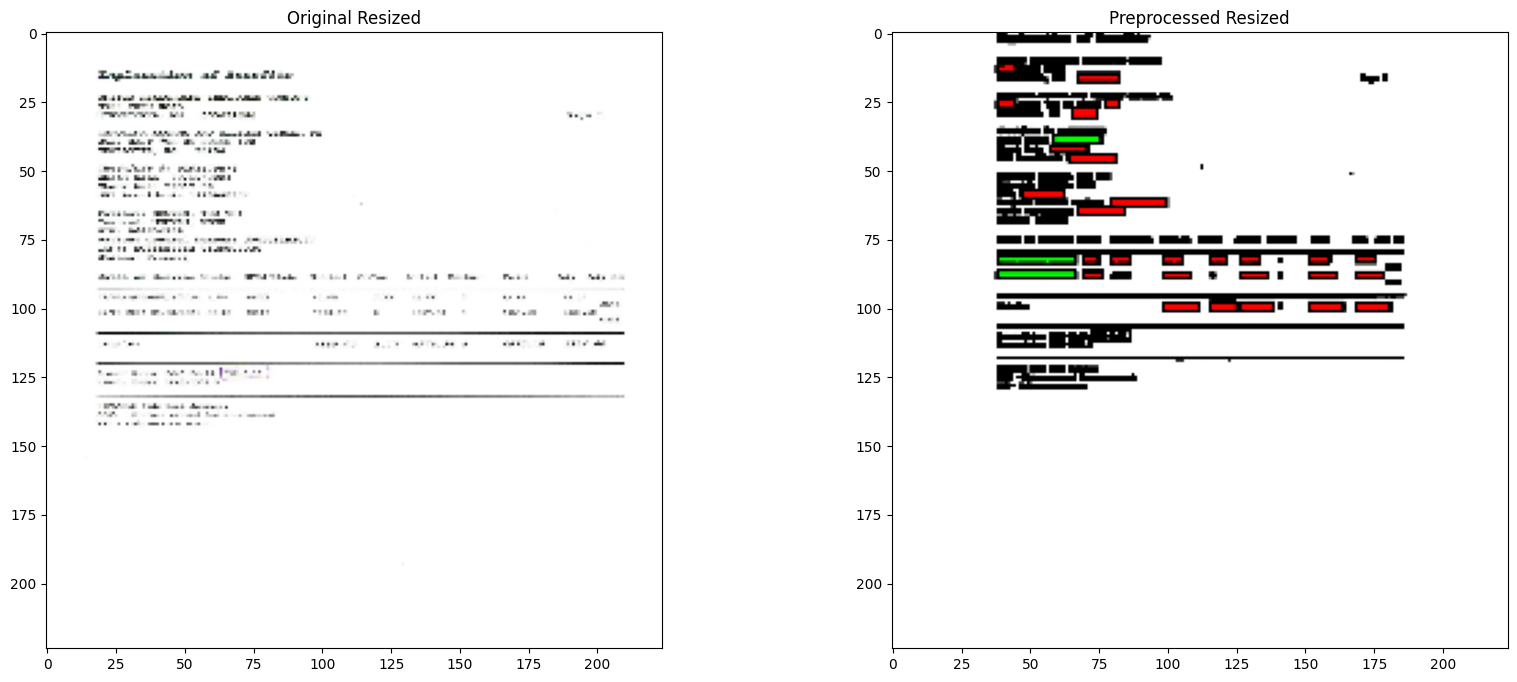

In [60]:
img_name = '24691_20240926_99995270_page_1.jpg'
IMG_SIZE = 224
img = load_img(os.path.join(IMAGES_PATH, img_name))
img = img_to_array(img)
img_normalized = img / 255.0 # Normalize

print(img_name, img.shape)

img_resized = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
img_resized_normalized = img_resized / 255.0 # Normalize

with open(os.path.join(IMAGES_OCR_PATH, img_name.replace('.jpg', '.json'))) as f:
    img_ocr = json.load(f)
img_pp = doc_preprocessing(img, img_ocr)
img_pp_resized = tf.image.resize(img_pp, (IMG_SIZE, IMG_SIZE))
img_pp_resized_normalized = img_pp_resized / 255.0 # Normalize
img_pp_normalized = img_pp / 255.0 # Normalize
                         
print_2_images_from_array(img_normalized, img_pp_normalized, 'Original', 'Preprocessed')
print_2_images_from_array(img_resized_normalized, img_pp_resized_normalized, 'Original Resized', 'Preprocessed Resized')

### Preprocess and save image dataset

In [ ]:
# Execute preprocessing and save preprocessed images

for dirpath, dirnames, filenames in os.walk(IMAGES_PATH):
    for i, filename in enumerate(filenames):
        print(f'{i}/{len(filenames)}')
        image_path = os.path.join(dirpath, filename)
        image_ocr_path = os.path.join(IMAGES_OCR_PATH, filename.replace('.jpg', '.json'))
        img_pp = preprocess_image(image_path, image_ocr_path)
        img_pp_bgr = cv2.cvtColor(img_pp, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(PREPROCESSED_IMAGES_PATH, filename), img_pp_bgr)

## Set preprocess images from dataset

If the images were already preprocessed and store, they can be directly loaded setting the folder path.

In [16]:
PREPROCESSED_IMAGES_PATH = '/home/dut-ftp-user/Documents/miguel/JupyterWorkspace/Similarity Classifier Siamese Network/All Templates Dataset v9/preprocessed_images'

# Model

The model is a Siamese Network that uses a vision model to generate image embeddings. It processes an anchor image, a positive sample, and a negative sample, computing their embeddings. These embeddings are then used to calculate the loss function, which helps the model learn to differentiate between similar and dissimilar images.

There are different hyperparameters that can be adjusted for the model training, they all can be set here:

In [17]:
IMG_SIZE = 224 # Image Size: Recommended value is 224 as most vision models use this image size
BATCH_SIZE = 128 # Batch size: The bigger the better, the limitation is the engine with which the model is trained
LEARNING_RATE = 0.00005 # Learning Rate: This value will have a big impact in the model training, as the batch size is reduced, the learning rate should be reduced too and viceversa.
MARGIN = 1 # Margin. This margin is used in the loss function. Generally, it will be the distance to aim for between the difference between positive sample distance and negative sample distance.
EPOCHS = 5 # Number of epochs to be performed.
FREEZE_LAYERS_PERCENTAGE = 0 # Layers percentage to be frozen in the training. This can be useful if a pretrained model is used and there is not a lot of data. Recommendation: use general model as base and freeze a high percentage of layers(or all) so that only the last layers(or last if all are frozen) are trained and the model can learn faster with less data.
FREEZE_N_LAYERS = 3 # Freeze first N layers. Same as FREEZE_LAYERS_PERCENTAGE but with absolute values
MODEL_ARCHITECTURE = tf.keras.applications.ResNet50V2 # Model Architecture, needs to be a tensorflow/keras model
LAST_LAYER_SIZE = 2048 # Size of the added last dense layer in case all layers are frozen for the transfer learning
PRETRAINED_WEIGHTS = 'imagenet' # Weights of pretrained model to do transfer learning with

## Data Generator

The data generator will take the triplets and send them to the model for training and testing.

In [18]:
class TripleGenerator(tf.keras.utils.Sequence):
    def __init__(self, gen1, gen2, gen3, **kwargs):
        super().__init__(**kwargs)
        self.gen1 = gen1
        self.gen2 = gen2
        self.gen3 = gen3

    def __len__(self):
        return len(self.gen1)

    def __getitem__(self, i):
        x1 = tf.convert_to_tensor(self.gen1[i])
        x2 = tf.convert_to_tensor(self.gen2[i])
        x3 = tf.convert_to_tensor(self.gen3[i])

        return (x1,x2,x3)
        # return [x1,x2,x3]

In [19]:
def create_generator(folder,dataset, column, datagen, batch_size=BATCH_SIZE):
    generator = datagen.flow_from_dataframe(dataframe=dataset,
                                            directory=folder,
                                            x_col=column,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=batch_size,
                                            class_mode=None,
                                            shuffle=False)
    return generator

In [12]:
with strategy.scope():
    datagen = ImageDataGenerator(rescale=1/255.)
    train_generator1 = create_generator(PREPROCESSED_IMAGES_PATH,train,'anchor', datagen)
    train_generator2 = create_generator(PREPROCESSED_IMAGES_PATH,train,'pos', datagen)
    train_generator3 = create_generator(PREPROCESSED_IMAGES_PATH,train,'neg', datagen)
    
    test_generator1 = create_generator(PREPROCESSED_IMAGES_PATH,test,'anchor', datagen)
    test_generator2 = create_generator(PREPROCESSED_IMAGES_PATH,test,'pos', datagen)
    test_generator3 = create_generator(PREPROCESSED_IMAGES_PATH,test,'neg', datagen)
    
    train_generator = TripleGenerator(train_generator1,train_generator2,train_generator3)
    test_generator = TripleGenerator(test_generator1,test_generator2,test_generator3)

Found 9343 validated image filenames.
Found 9343 validated image filenames.
Found 9343 validated image filenames.
Found 1746 validated image filenames.
Found 1746 validated image filenames.
Found 1746 validated image filenames.


## Model Architecture

In [20]:
# Define model architecture
with strategy.scope():
    embeddings_base_model = MODEL_ARCHITECTURE(
        include_top=False,
        weights=PRETRAINED_WEIGHTS,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        pooling='avg'
    )

2025-02-05 14:42:04.640987: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [21]:
# Freeze the first % of layers
with strategy.scope():
    for i, layer in enumerate(embeddings_base_model.layers):
        if i < FREEZE_N_LAYERS: # Freeze layers if they are below a certain number
            layer.trainable = False
        if i < len(embeddings_base_model.layers) * FREEZE_LAYERS_PERCENTAGE: # Freeze layers if they are the N% first
            layer.trainable = False
        elif isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False  # Freeze BatchNorm layers
        else:
            layer.trainable = True

In [22]:
# Add last dense layer and normalize embeddings
with strategy.scope():
    embeddings_model = models.Sequential([
        embeddings_base_model,  # Model architecture
        layers.Dense(LAST_LAYER_SIZE, activation=None, kernel_initializer='he_normal', bias_initializer='zeros'),  # Last Layer
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # Normalize last layer
    ])

In [23]:
# Model summary
embeddings_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 2048)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,761,152 (105.90 MB)

 Trainable params: 27,670,272 (105.55 MB)

 Non-trainable params: 90,880 (355.00 KB)

In [24]:
# Create siamese network architecture for anchor, positive and negative
with strategy.scope():
    image_input1 = Input(shape=(IMG_SIZE,IMG_SIZE,3),name='Image1')
    image_input2 = Input(shape=(IMG_SIZE,IMG_SIZE,3),name='Image2')
    image_input3 = Input(shape=(IMG_SIZE,IMG_SIZE,3),name='Image3')
    
    anchor = embeddings_model(image_input1)
    positive = embeddings_model(image_input2)
    negative = embeddings_model(image_input3)
    
    siamese_network = Model(inputs=[image_input1,image_input2,image_input3], outputs=[anchor,positive,negative])

In [25]:
# Define Siamese model
with strategy.scope():
    class SiameseModel(Model):
        def __init__(self, siamese_network, margin=0.5):
            super().__init__()
            self.siamese_network = siamese_network
            self.margin = margin
            self.loss_tracker = metrics.Mean(name='loss')
            
        def call(self, inputs):
            return self.siamese_network(inputs)
        
        def train_step(self, data):
            with tf.GradientTape() as tape:
                loss = self._compute_loss(data)
            gradients = tape.gradient(loss,self.siamese_network.trainable_weights)
            self.optimizer.apply_gradients(zip(gradients,self.siamese_network.trainable_weights))
            self.loss_tracker.update_state(loss)
            return {"loss": self.loss_tracker.result()}
        
        def test_step(self, data):
            loss = self._compute_loss(data)
            self.loss_tracker.update_state(loss)
            return {"loss": self.loss_tracker.result()}
        
        def _compute_loss(self, data): # Define loss function
            anchor, positive, negative = self.siamese_network(data)
    
            # Original Triplet Loss
            # pos_dist = tf.reduce_sum(tf.square(anchor-positive), -1) 
            # neg_dist = tf.reduce_sum(tf.square(anchor-negative), -1)
            # loss = pos_dist - neg_dist + self.margin
            # loss = tf.maximum(loss, 0.0)

            # Variation Triplet Loss
            pos_dist = tf.reduce_sum(tf.square(anchor-positive), -1) 
            neg_dist = tf.reduce_sum(tf.square(anchor-negative), -1)
            loss = pos_dist - neg_dist + self.margin + (pos_dist - 0.2)
            loss = tf.maximum(loss, 0.0)

            # Range Triplet loss (penalizes any distnace between positive samples and the negative distance needs to be bigger than the threshold)
            # pos_dist = tf.reduce_sum(tf.square(anchor-positive), -1) 
            # neg_dist = tf.reduce_sum(tf.square(anchor-negative), -1)
            # loss = pos_dist + tf.maximum(self.margin - neg_dist, 0.0)

            # Cosine triplet loss
            # pos_similarity = tf.reduce_sum(anchor * positive, axis=-1)  # Cosine similarity
            # neg_similarity = tf.reduce_sum(anchor * negative, axis=-1)
            # pos_distance = 1 - pos_similarity  # Cosine distance (1 - similarity)
            # neg_distance = 1 - neg_similarity  # Cosine distance (1 - similarity)
            # loss = tf.maximum(pos_distance - neg_distance + self.margin, 0.0)

            # Cosine range triplet loss
            # pos_similarity = tf.reduce_sum(anchor * positive, axis=-1)  # Cosine similarity
            # neg_similarity = tf.reduce_sum(anchor * negative, axis=-1)
            # pos_distance = 1 - pos_similarity  # Cosine distance (1 - similarity)
            # neg_distance = 1 - neg_similarity  # Cosine distance (1 - similarity)
            # loss = pos_distance + tf.maximum(self.margin - neg_distance, 0.0)

            return loss 
        
        @property
        def metrics(self):
            return [self.loss_tracker]

In [26]:
with strategy.scope():
    siamese_model = SiameseModel(siamese_network, margin=MARGIN)
    siamese_model.compile(optimizer=optimizers.AdamW(learning_rate=LEARNING_RATE)) # Define optimizer
    siamese_model.build(input_shape=[(None, 224, 224, 3), (None, 224, 224, 3), (None, 224, 224, 3)])

# Model Training


In [ ]:
try:
    history = siamese_model.fit(train_generator, validation_data=test_generator, epochs=EPOCHS, shuffle=True)
except KeyboardInterrupt:
    print("\nTraining Stopped!")

Epoch 1/5
13/73 ━━━━━━━━━━━━━━━━━━━━ 22:25 22s/step - loss: 1.0002

# Save Trained Model

In [78]:
STORE_MODEL_PATH = "model_final_approach_v1.keras"

In [79]:
with strategy.scope():
    siamese_network.save(STORE_MODEL_PATH)

# Load model

In [ ]:
LOAD_MODEL_PATH = 'model.keras'

In [ ]:
# with strategy.scope():
#     siamese_network.load_weights(LOAD_MODEL_PATH)

# Inference

In [27]:
datagen = ImageDataGenerator(rescale=1/255.)
def preprocess_image_with_datagen(datagen, image_path, img_size=IMG_SIZE):
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img)
    img = datagen.standardize(img)
    return img

In [28]:
def get_doc_embeddings(model, datagen, image_path):
    img = preprocess_image_with_datagen(datagen, image_path)
    emb = model.predict(np.expand_dims(img,axis=0))
    return emb

In [29]:
def get_distance_of_2_images(model, datagen, image1_path, image2_path):
    emb1 = get_doc_embeddings(model, datagen, image1_path)
    emb2 = get_doc_embeddings(model, datagen, image2_path)    
    return L2(emb1,emb2)
    # return cs(emb1,emb2)

In [30]:
def read_image(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    img /= 255.
    return img

In [31]:
def print_2_images(image1_path, image2_path, plot_axis='off'):    
    img1 = read_image(image1_path)
    img2 = read_image(image2_path)    
    f, axarr = plt.subplots(1,2,figsize=(20, 8))
    axarr[0].imshow(img1)
    axarr[0].title.set_text(os.path.basename(image1_path))
    axarr[0].axis(plot_axis)
    axarr[1].imshow(img2)
    axarr[1].title.set_text(os.path.basename(image2_path))
    axarr[1].axis(plot_axis)
    plt.show()

## Load model for inference

In [50]:
image_embeddings_model = siamese_network.layers[-1]

# Get all documents embeddings

In [51]:
def get_doc_embeddings_batch(model, datagen, batch_filenames, img_size=IMG_SIZE):
    imgs = [preprocess_image_with_datagen(datagen, image_path, img_size) for image_path in batch_filenames]
    imgs_array = np.stack(imgs)
    embeddings = model.predict(imgs_array, batch_size=len(batch_filenames))
    return embeddings

def get_all_embeddings(folder_path, filter_doc_names=[], batch_size=BATCH_SIZE):
    all_embeddings = {}
    batch = []
    batch_filenames = []
    for dirpath, dirnames, filenames in os.walk(folder_path):
        if filter_doc_names: 
            filenames_list = [f for f in filenames if f in filter_doc_names]
        else:
            filenames_list = filenames
        for filename in filenames_list:
            batch.append(filename)
            batch_filenames.append(os.path.join(dirpath, filename))
            if len(batch) == batch_size:
                embeddings = get_doc_embeddings_batch(image_embeddings_model, datagen, batch_filenames)
                all_embeddings.update({filename: emb for filename, emb in zip(batch, embeddings)})
                batch = []  
                batch_filenames = [] 
        if batch:
            embeddings = get_doc_embeddings_batch(image_embeddings_model, datagen, batch_filenames)
            all_embeddings.update({filename: emb for filename, emb in zip(batch, embeddings)})
    return all_embeddings

In [52]:
filter_doc_names = list(data['anchor'].values) + list(data['pos'].values) + list(data['neg'].values )

In [53]:
all_embeddings = get_all_embeddings(PREPROCESSED_IMAGES_PATH, filter_doc_names, batch_size=BATCH_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [54]:
train_set_embeddings = {}
for i, row in train.iterrows():
    train_set_embeddings[row['anchor']] = all_embeddings[row['anchor']]
    train_set_embeddings[row['pos']] = all_embeddings[row['pos']]
    train_set_embeddings[row['neg']] = all_embeddings[row['neg']]

In [55]:
test_set_embeddings = {}
for i, row in test.iterrows():
    test_set_embeddings[row['anchor']] = all_embeddings[row['anchor']]
    test_set_embeddings[row['pos']] = all_embeddings[row['pos']]
    test_set_embeddings[row['neg']] = all_embeddings[row['neg']]

In [56]:
template_mapping = {}
for i, row in data.iterrows():
    template_mapping[row['anchor']] = row['label']
    template_mapping[row['pos']] = row['label']
    template_mapping[row['neg']] = row['neg_label']

# Training and Test with predictions

In [57]:
METRIC = 'euclidean' # how to calculate the distance between the embeddings. It depends on the loss function with which the model was trained on.
# METRIC = 'cosine'
THRESHOLD = 1 # The threshold to determine if 2 images belong to the same template or not based on if the distance between their embeddings is less than this threshold. It is recommended to be the same value as the margin or slightly less.

In [58]:
def get_set_with_preds(triplets, embeddings, template_mapping):
    doc_names = list(embeddings.keys())
    embeddings_array = np.array([emb.flatten() for emb in embeddings.values()])
    distances = cdist(embeddings_array, embeddings_array, metric=METRIC)
    pos_neg_distances = []
    for i, row in triplets.iterrows():
        index_anchor = doc_names.index(row['anchor'])
        index_pos = doc_names.index(row['pos'])
        index_neg = doc_names.index(row['neg'])
        pos_neg_distances.append([distances[index_anchor][index_pos], distances[index_anchor][index_neg]])
    triplets_with_preds = triplets.copy()
    triplets_with_preds.loc[:,['pos_dist','neg_dist']] = pos_neg_distances
    return triplets_with_preds

In [59]:
train_with_preds = get_set_with_preds(train, all_embeddings, template_mapping)

In [60]:
test_with_preds = get_set_with_preds(test, all_embeddings, template_mapping)

# Analysis Results

## Box-and-whisker plot

The bos-and-whiskers plot displays the distance between the positive pairs and the negative pair to have a visual image of the distance between the images that have the same template and that have different templates. These plots will help to find the best threshold to determine if two images belong to the same template or not.

In [61]:
def box_and_whisker_plot(pos_dist, neg_dist):
    plt.figure(figsize=(20,6))
    df = pd.DataFrame({'Category': ['Positive'] * len(pos_dist) + ['Negative'] * len(neg_dist),  'Values': pos_dist + neg_dist})
    colors = ["skyblue", "lightcoral"] 
    sns.boxplot(x='Values', y='Category', data=df, hue='Category')
    plt.show()

### Triplets only

#### Train

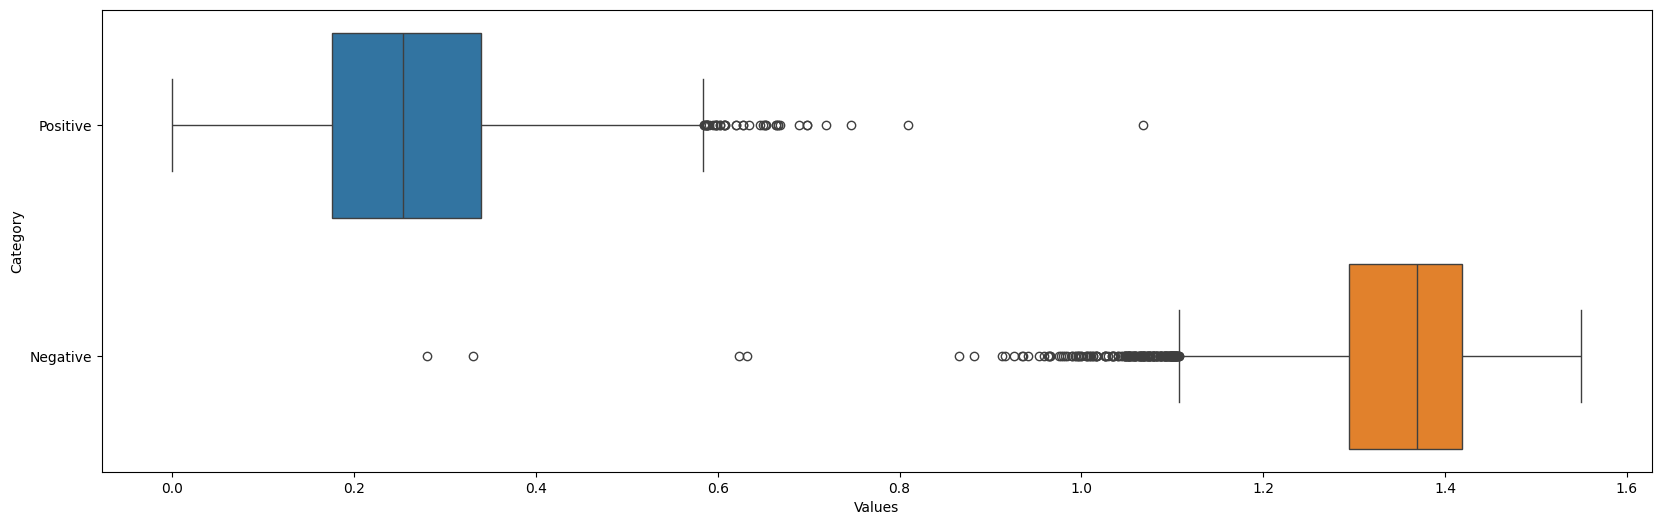

In [62]:
box_and_whisker_plot(list(train_with_preds['pos_dist'].values), list(train_with_preds['neg_dist'].values))

In [63]:
len(train_with_preds[(train_with_preds['pos_dist']<THRESHOLD) & (train_with_preds['neg_dist']>THRESHOLD)])/len(train_with_preds)

0.9945155393053017

#### Test

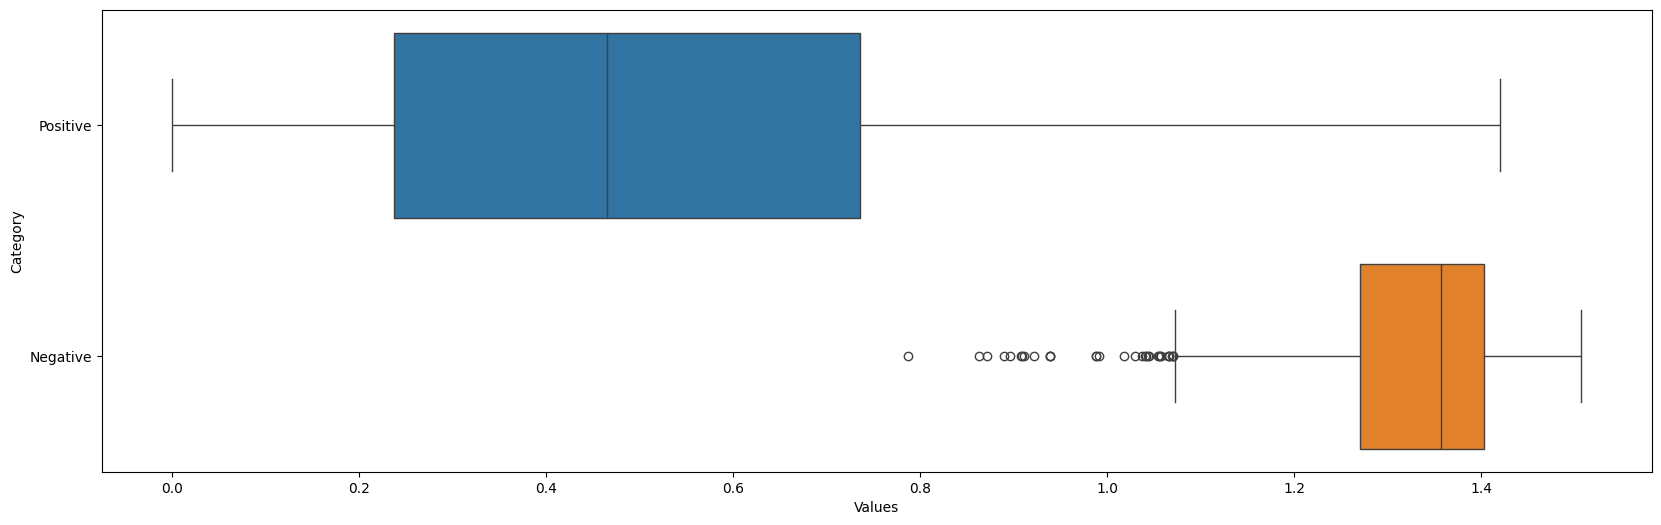

In [64]:
box_and_whisker_plot(list(test_with_preds['pos_dist'].values), list(test_with_preds['neg_dist'].values))

In [65]:
len(test_with_preds[(test_with_preds['pos_dist']<THRESHOLD) & (test_with_preds['neg_dist']>THRESHOLD)])/len(test_with_preds)

0.9115577889447236

### All combinations

Calculate the distance of the embedding of not only the triplets, but all possible combinations of the images of the training and test set.

In [66]:
def get_pos_and_neg_distances(embeddings, template_mapping):
    doc_names = list(embeddings.keys())
    embeddings_array = np.array([emb.flatten() for emb in embeddings.values()])
    distances = cdist(embeddings_array, embeddings_array, metric=METRIC)
    pos_dist = []
    neg_dist = []
    for i in range(len(doc_names)):
        for j in range(i + 1, len(doc_names)):
            distance = distances[i, j]
            doc_name1, doc_name2 = doc_names[i], doc_names[j]
            same_template = template_mapping[doc_name1] == template_mapping[doc_name2]
            if same_template:
                pos_dist.append(distance)
            else: 
                neg_dist.append(distance)
                
    return pos_dist, neg_dist

#### Train

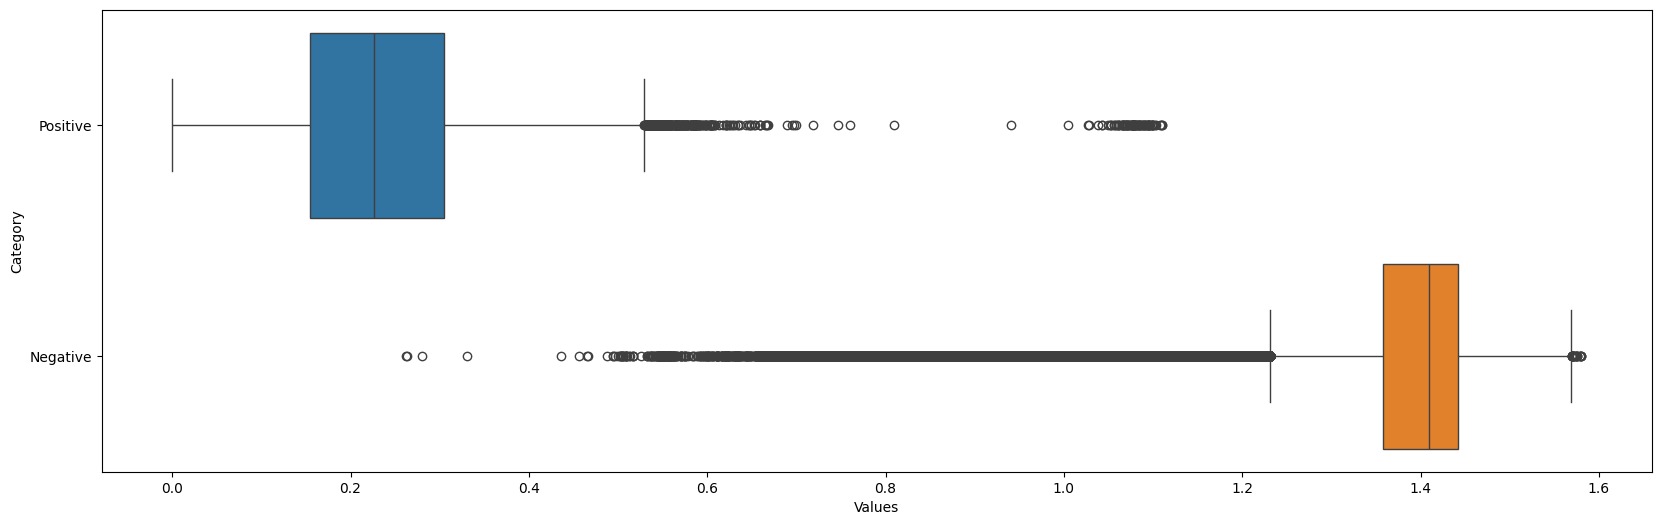

In [67]:
pos_dist, neg_dist = get_pos_and_neg_distances(train_set_embeddings, template_mapping)
box_and_whisker_plot(pos_dist, neg_dist)

In [68]:
print('Positive accuracy: ', len([dist for dist in pos_dist if dist < THRESHOLD])/len(pos_dist))
print('Negative accuracy: ',len([dist for dist in neg_dist if dist > THRESHOLD])/len(neg_dist))

Positive accuracy:  0.9975601077619072
Negative accuracy:  0.9955825691380221


In [69]:
print('Positive accuracy: ', len([dist for dist in pos_dist if dist < THRESHOLD])/len(pos_dist))
print('Negative accuracy: ',len([dist for dist in neg_dist if dist > THRESHOLD])/len(neg_dist))

Positive accuracy:  0.9975601077619072
Negative accuracy:  0.9955825691380221


#### Test

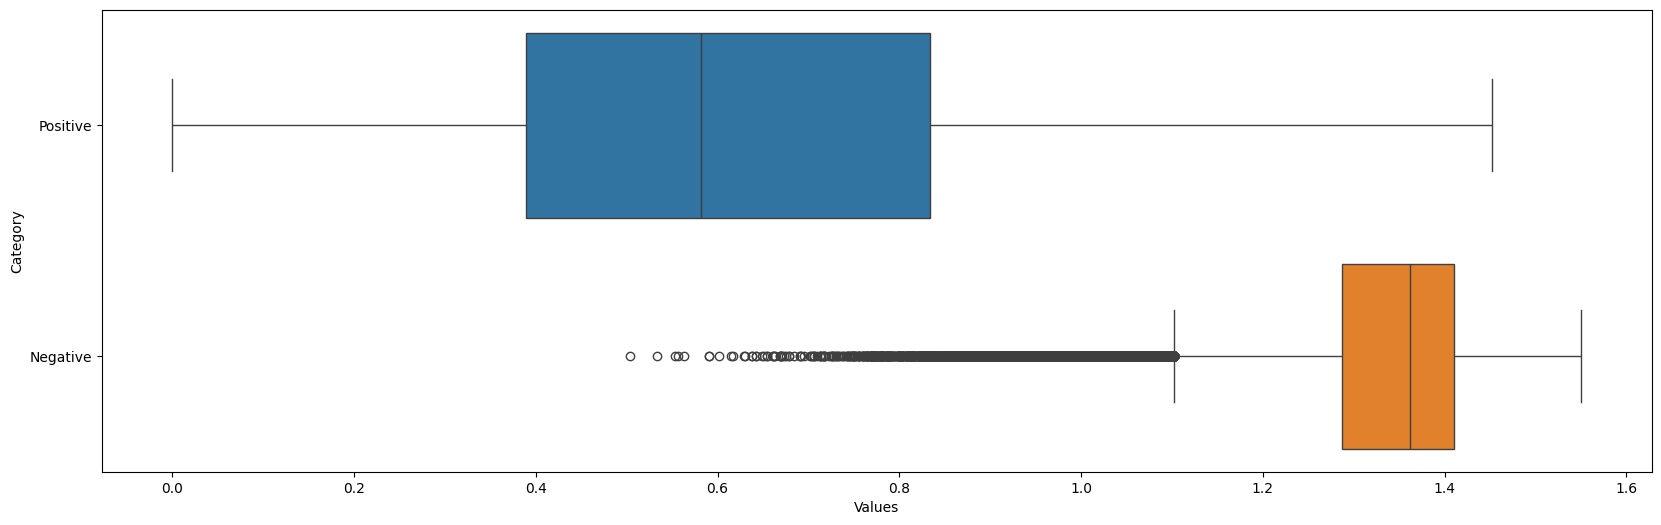

In [70]:
pos_dist, neg_dist = get_pos_and_neg_distances(test_set_embeddings, template_mapping)
box_and_whisker_plot(pos_dist, neg_dist)

In [71]:
print('Positive accuracy: ', len([dist for dist in pos_dist if dist < THRESHOLD])/len(pos_dist))
print('Negative accuracy: ',len([dist for dist in neg_dist if dist > THRESHOLD])/len(neg_dist))

Positive accuracy:  0.8788853161843515
Negative accuracy:  0.9872537565967047


## False Negative and False Postive Analysis

### Train

In [ ]:
# False Negative
i = 0
exclude_templates = []
innacurate_sample = train_with_preds[(train_with_preds['pos_dist']>THRESHOLD) & (~train_with_preds['label'].isin(exclude_templates))].sort_values(by='pos_dist', ascending=False).iloc[i]
print(i, 'Label: ', innacurate_sample['label'] ,'Distance: ', innacurate_sample['pos_dist'])
print(innacurate_sample['anchor'], innacurate_sample['pos'])
print_2_images(os.path.join(IMAGES_PATH, innacurate_sample['anchor']), os.path.join(IMAGES_PATH, innacurate_sample['pos']))
print_2_images(os.path.join(PREPROCESSED_IMAGES_PATH, innacurate_sample['anchor']), os.path.join(PREPROCESSED_IMAGES_PATH, innacurate_sample['pos']), plot_axis='on')
i += 1

In [ ]:
# False Positive
# j = 0
exclude_templates = []
innacurate_sample = train_with_preds[(train_with_preds['neg_dist']<THRESHOLD) & (~train_with_preds['label'].isin(exclude_templates))].sort_values(by='neg_dist').iloc[j]
print('Anchor Label: ', innacurate_sample['label'])
print('Negative Label: ', innacurate_sample['neg_label'])
print(j, 'Distance: ', innacurate_sample['neg_dist'])
print(innacurate_sample['anchor'], innacurate_sample['neg'])
# print_2_images(os.path.join(IMAGES_PATH, innacurate_sample['anchor']), os.path.join(IMAGES_PATH, innacurate_sample['neg']))
print_2_images(os.path.join(PREPROCESSED_IMAGES_PATH, innacurate_sample['anchor']), os.path.join(PREPROCESSED_IMAGES_PATH, innacurate_sample['neg']), plot_axis='on')
j+=1

### Test

33 Label:  aetna vertical - template 0_3 Distance:  1.165719544305562
25259_20241001_99995272_page_3.jpg 24879_20240927_99995270_page_1.jpg


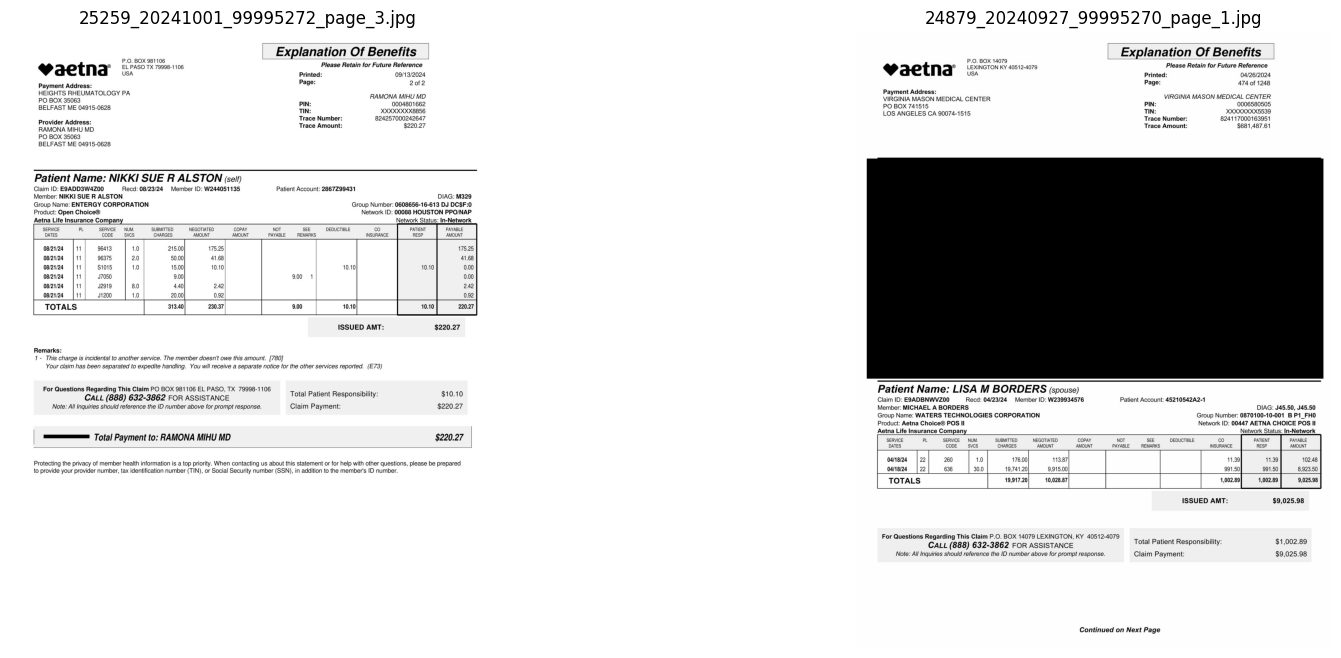

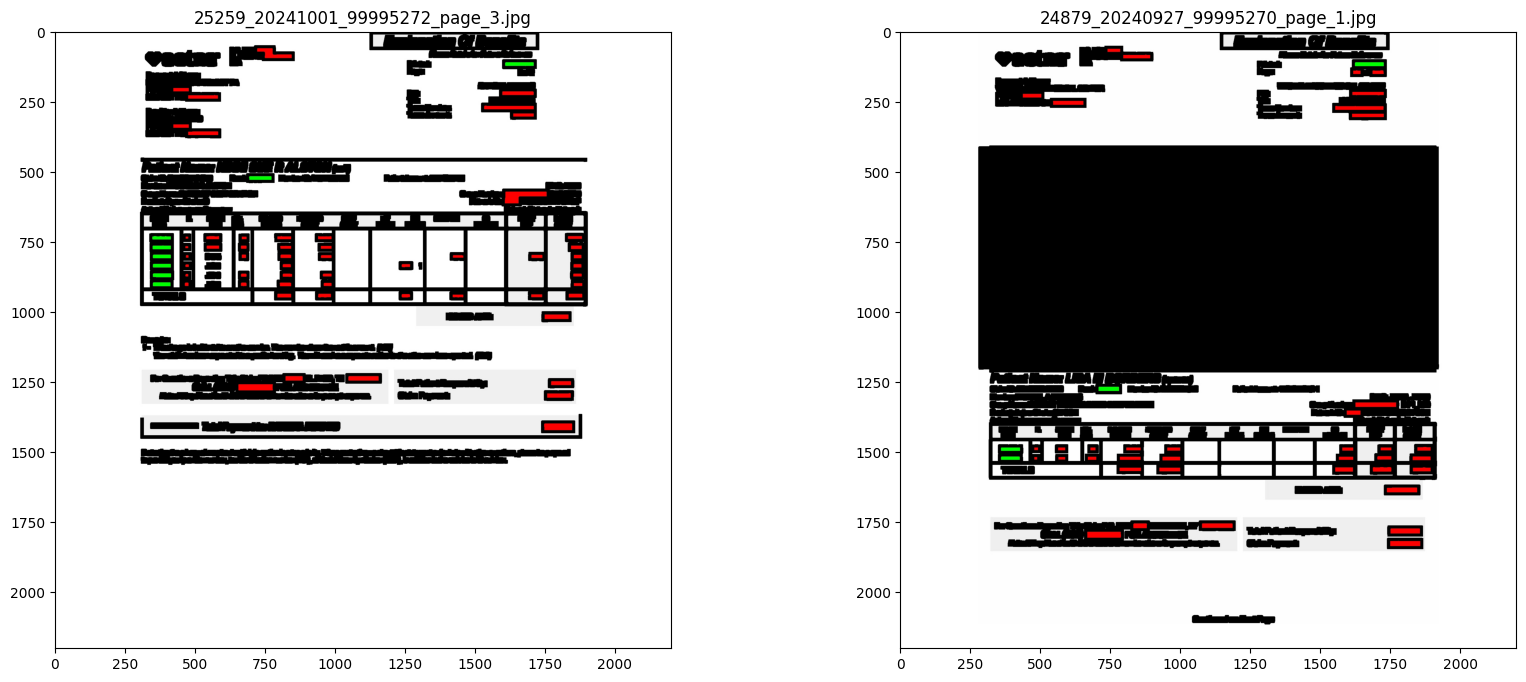

In [114]:
# False Negative
# i = 0
exclude_templates = []
# innacurate_sample = test_with_preds[(test_with_preds['pos_dist']>THRESHOLD) & (~test_with_preds['label'].isin(exclude_templates))].sort_values(by='pos_dist', ascending=False).iloc[i]
innacurate_sample = test_with_preds[(test_with_preds['pos_dist']>THRESHOLD) & (~test_with_preds['label'].isin(exclude_templates))].sort_values(by='pos_dist', ascending=True).iloc[i]
print(i, 'Label: ', innacurate_sample['label'] ,'Distance: ', innacurate_sample['pos_dist'])
print(innacurate_sample['anchor'], innacurate_sample['pos'])
print_2_images(os.path.join(IMAGES_PATH, innacurate_sample['anchor']), os.path.join(IMAGES_PATH, innacurate_sample['pos']))
print_2_images(os.path.join(PREPROCESSED_IMAGES_PATH, innacurate_sample['anchor']), os.path.join(PREPROCESSED_IMAGES_PATH, innacurate_sample['pos']), plot_axis='on')
i += 1

Anchor Label:  ust_finance_phase_1_2
Negative Label:  Labelmakers Group Pty Ltd 2
4 Distance:  0.8956694767798499
154_UST_15CACB_page_1.jpg 19012023_15081686InvNo 875346 18-Jan-2023.jpg


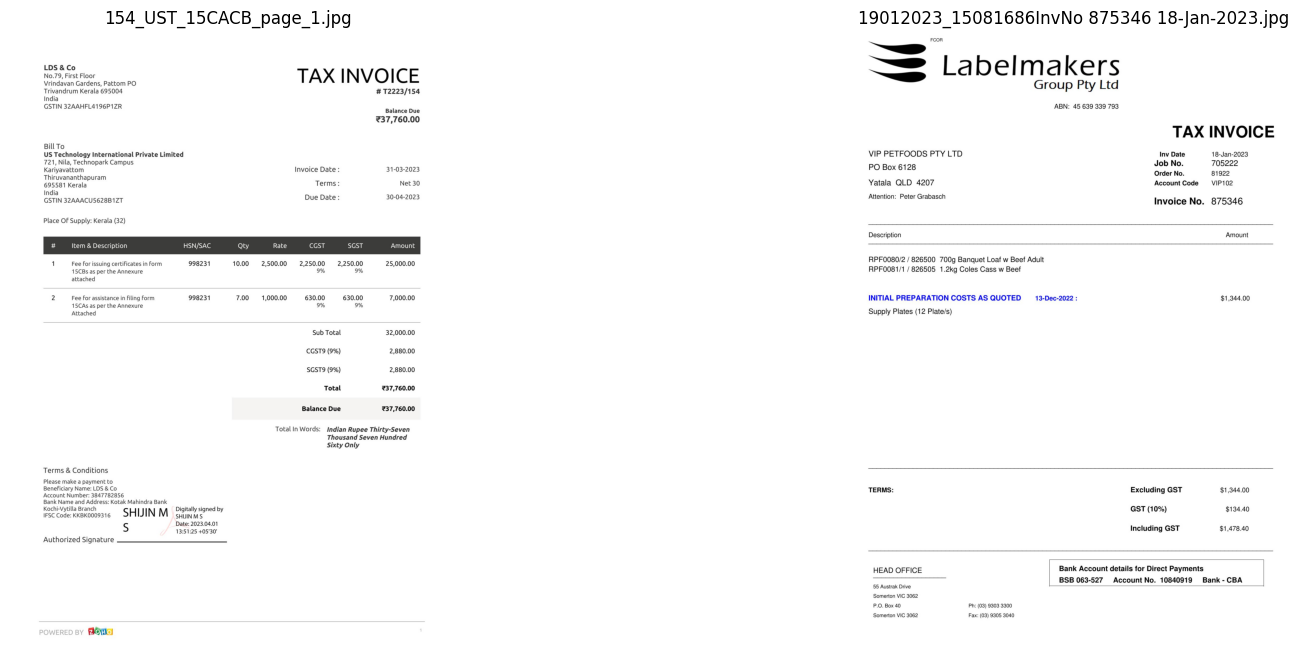

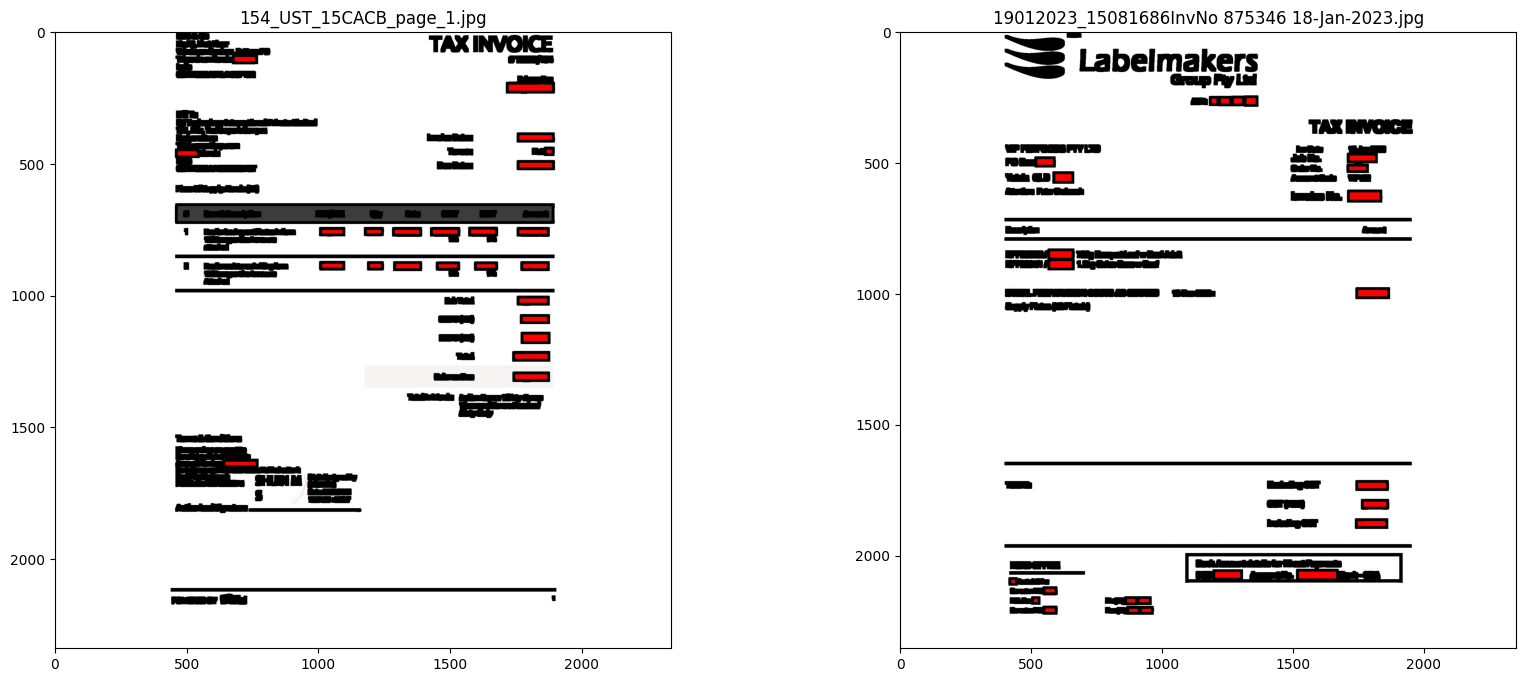

In [120]:
# False Positive
# j=0
exclude_templates = []
innacurate_sample = test_with_preds[(test_with_preds['neg_dist']<THRESHOLD) & (~test_with_preds['label'].isin(exclude_templates))].sort_values(by='neg_dist').iloc[j]
print('Anchor Label: ', innacurate_sample['label'])
print('Negative Label: ', innacurate_sample['neg_label'])
print(j, 'Distance: ', innacurate_sample['neg_dist'])
print(innacurate_sample['anchor'], innacurate_sample['neg'])
print_2_images(os.path.join(IMAGES_PATH, innacurate_sample['anchor']), os.path.join(IMAGES_PATH, innacurate_sample['neg']))
print_2_images(os.path.join(PREPROCESSED_IMAGES_PATH, innacurate_sample['anchor']), os.path.join(PREPROCESSED_IMAGES_PATH, innacurate_sample['neg']), plot_axis='on')
j+=1


## General Confusion Matrix

Obtain the confusion matrix to visualize the metrics better.

In [73]:
def get_confusion_matrix(embeddings, template_mapping, threshold=THRESHOLD):
    # Extract embedding names and ensure embeddings are in 2D array format
    doc_names = list(embeddings.keys())
    embeddings_array = np.array([emb.flatten() for emb in embeddings.values()])
    distances = cdist(embeddings_array, embeddings_array, metric=METRIC)
    confusion_matrix = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
    confusion_matrix_content = {'TP': [], 'TN': [], 'FP': [], 'FN': []}
    for i in range(len(doc_names)):
        for j in range(i + 1, len(doc_names)):
            distance = distances[i, j]
            doc_name1, doc_name2 = doc_names[i], doc_names[j]
            same_template = template_mapping[doc_name1] == template_mapping[doc_name2]
            save_content = {'doc_name1': doc_name1, 'doc_name2': doc_name2, 'distance': distance, 'template_doc1': template_mapping[doc_name1], 'template_doc2': template_mapping[doc_name2]}
            if distance < threshold:
                if same_template:  # True Positive
                    confusion_matrix['TP'] += 1
                    confusion_matrix_content['TP'].append(save_content)
                else:  # False Positive
                    confusion_matrix['FP'] += 1
                    confusion_matrix_content['FP'].append(save_content)
            else:
                if same_template:  # False Negative
                    confusion_matrix['FN'] += 1
                    confusion_matrix_content['FN'].append(save_content)
                else:  # True Negative
                    confusion_matrix['TN'] += 1
                    confusion_matrix_content['TN'].append(save_content)

    return confusion_matrix, confusion_matrix_content

In [74]:
def get_cm_percentages(confusion_matrix):
    positives = confusion_matrix['TP'] + confusion_matrix['FN']
    negatives = confusion_matrix['TN'] + confusion_matrix['FP']
    tpr = (confusion_matrix['TP'] / positives) * 100  # True Positive Rate
    fnr = (confusion_matrix['FN'] / positives) * 100  # False Negative Rate
    tnr = (confusion_matrix['TN'] / negatives) * 100  # True Negative Rate
    fpr = (confusion_matrix['FP'] / negatives) * 100  
    return { 'TP': round(tpr, 2), 'TN': round(tnr, 2),  'FP': round(fpr, 2),  'FN': round(fnr, 2)   }

### Train

In [75]:
train_cm, train_cm_content = get_confusion_matrix(train_set_embeddings, template_mapping)
print(train_cm)
get_cm_percentages(train_cm)

{'TP': 39250, 'TN': 4626517, 'FP': 20528, 'FN': 96}


{'TP': 99.76, 'TN': 99.56, 'FP': 0.44, 'FN': 0.24}

### Test

In [76]:
test_cm, test_cm_content = get_confusion_matrix(test_set_embeddings, template_mapping)
print(test_cm)
get_cm_percentages(test_cm)

{'TP': 4920, 'TN': 245066, 'FP': 3164, 'FN': 678}


{'TP': 87.89, 'TN': 98.73, 'FP': 1.27, 'FN': 12.11}

### All

In [77]:
all_cm, all_cm_content = get_confusion_matrix(all_embeddings, template_mapping)
print(all_cm)
get_cm_percentages(all_cm)

{'TP': 44170, 'TN': 7034822, 'FP': 43659, 'FN': 774}


{'TP': 98.28, 'TN': 99.38, 'FP': 0.62, 'FN': 1.72}

## Get all documents distance from Confusion Matrix output

In [96]:
all_docs_distances = []
for docs_tuples in all_cm_content.values():
    all_docs_distances.extend(docs_tuples)

In [97]:
pd.DataFrame(all_docs_distances).to_csv('all_docs_distances_2.csv', index=False)

## Template Confusion Matrix
Confusion matrix of the multiple templates as a multiclass classification. We can only see in this matrix True Positives and False Positives

In [ ]:
def get_template_confusion_matrix(embeddings, template_mapping):
    confusion_matrix = {}
    doc_names = list(embeddings.keys())
    embeddings_array = np.array([emb.flatten() for emb in embeddings.values()])
    distances = cdist(embeddings_array, embeddings_array, metric=METRIC)
    for i in range(len(doc_names)):
        doc_name1 = doc_names[i]
        if template_mapping[doc_name1] not in confusion_matrix:
            confusion_matrix[template_mapping[doc_name1]] = {}
        for j in range(i + 1, len(doc_names)):
            doc_name2 = doc_names[j]
            if template_mapping[doc_name1] not in confusion_matrix[template_mapping[doc_name1]]:
                confusion_matrix[template_mapping[doc_name1]][template_mapping[doc_name1]] = 0
            if template_mapping[doc_name2] not in confusion_matrix[template_mapping[doc_name1]]:
                confusion_matrix[template_mapping[doc_name1]][template_mapping[doc_name2]] = 0
            if template_mapping[doc_name2] not in confusion_matrix:
                confusion_matrix[template_mapping[doc_name2]] = {}
            if template_mapping[doc_name1] not in confusion_matrix[template_mapping[doc_name2]]:
                confusion_matrix[template_mapping[doc_name1]][template_mapping[doc_name2]] = 0
            if template_mapping[doc_name1] not in confusion_matrix[template_mapping[doc_name2]]:
                confusion_matrix[template_mapping[doc_name2]][template_mapping[doc_name1]] = 0
            if j > i:
                distance = distances[i, j]
                if distance < THRESHOLD:
                    if confusion_matrix[template_mapping[doc_name2]][template_mapping[doc_name1]] > 0:
                        confusion_matrix[template_mapping[doc_name2]][template_mapping[doc_name1]] += 1
                    else:
                        confusion_matrix[template_mapping[doc_name1]][template_mapping[doc_name2]] += 1
    return dict(confusion_matrix)

In [ ]:
def print_template_confusion_matrix(confusion_dict):
    plt.figure(figsize=(35, 35))
    sns.heatmap(pd.DataFrame(confusion_dict), annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

**Train**

In [ ]:
# train_template_cm = get_template_confusion_matrix(train_set_embeddings, template_mapping)

In [ ]:
# print_template_confusion_matrix(train_template_cm)

In [ ]:
# # Show all False Positives
# for template1, other_templates in train_template_cm.items():
#     for template2, matches in other_templates.items():
#         if matches > 0 and template1 != template2:
#             print(matches, '\t', template1, '\t', template2)

**Test**

In [ ]:
# test_template_cm = get_template_confusion_matrix(test_set_embeddings, template_mapping)
# # print_template_confusion_matrix(test_template_cm)

In [ ]:
# # Show all False Positives
# for template1, other_templates in test_template_cm.items():
#     for template2, matches in other_templates.items():
#         if matches > 0 and template1 != template2:
#             print(matches, '\t', template1, '\t', template2)

# Real use case

In the real use case we take the first image of each template of the test set as a base set and we calculate the distance of these images and the rest, we classify the image to the closest template( using the base set) or we classify it as 'Others' if the distance is smaller than the threshold for every base document.

The output of this experiment, df_wrong_classification, will show all the documents wrongly classified.

In [199]:
def classify_docs(base_documents, embeddings, template_mapping, threshold=THRESHOLD):
    doc_names = list(embeddings.keys())
    embeddings_array = np.array([emb.flatten() for emb in embeddings.values()])
    distances = cdist(embeddings_array, embeddings_array, metric=METRIC)
    docs_classification = {}
    for i in range(len(doc_names)):
        doc_name = doc_names[i]
        min_distance = np.inf
        closest_template = 'Others'
        for template_name, base_doc_name in base_documents.items():
            base_doc_index = doc_names.index(base_doc_name)
            distance = distances[i, base_doc_index]
            if distance < THRESHOLD and distance < min_distance:
                min_distance = distance
                closest_template = template_name
        docs_classification[doc_name] = closest_template
    return docs_classification

In [200]:
df_one_doc_each_template = test.drop_duplicates(subset=['label'])[['label', 'anchor']].set_index('label')
one_doc_each_template = df_one_doc_each_template['anchor'].to_dict()

In [201]:
docs_classification = classify_docs(one_doc_each_template, test_set_embeddings, template_mapping, threshold=THRESHOLD)
df_docs_classification = pd.DataFrame({'anchor': docs_classification.keys(), 'closest_template': docs_classification.values()})
df_test_closest_template = test.merge(df_docs_classification)
df_wrong_classification = df_test_closest_template[df_test_closest_template['label']!=df_test_closest_template['closest_template']][['anchor', 'label', 'closest_template']].reset_index(drop=True)

In [202]:
df_wrong_classification

,anchor,label,closest_template
0,INI0300096028103._Invoice_UST.jpg,proglint,Others
1,1326700.jpg,06168AX,Separate-GVEC
2,10092021162315.jpg,VISY BOARD INDUSTRIAL PACKAGING DIVISION,Euro Pumps Engineering Pty Ltd
3,0__Visy Tax Invoice 24-03-2021-6586876.pdf.jpg,VISY BOARD INDUSTRIAL PACKAGING DIVISION,Euro Pumps Engineering Pty Ltd
4,INI0300096029106._Invoice_UST.jpg,proglint,82458
...,...,...,...
723,1328331.jpg,06109AX,BioTech Water Pty Ltd
724,10425_CMS1500_page_2.jpg,oscar - template_4_2,provider_claim_summary
725,26470_20241010_99995270_page_2.jpg,remittance_advice_powered_by_g,Thomson_reuters_3
726,25681_20241004_99995270_page_2.jpg,long_line_rend_prov2 - template 5,MLCR-Carrollton


# UMAP

In [ ]:
!pip install  umap-learn

In [ ]:
import umap
reducer = umap.UMAP()

In [ ]:
df_all_docs_distances = pd.DataFrame(all_docs_distances)
least_accurate_similar_templates = df_all_docs_distances[df_all_docs_distances['template_doc1'] == df_all_docs_distances['template_doc2']].sort_values(by='distance', ascending=False)['template_doc1'].unique()[:10]
least_accurate_diff_templates = df_all_docs_distances[df_all_docs_distances['template_doc1'] != df_all_docs_distances['template_doc2']].sort_values(by='distance', ascending=True)['template_doc1'].unique()[:10]

In [ ]:
filter_templates = least_accurate_similar_templates
# filter_templates = least_accurate_diff_templates
# filter_templates = list(template_mapping.values())

In [ ]:
filtered_all_embeddings = {image_name: embedding_value for image_name, embedding_value in all_embeddings.items() if template_mapping[image_name] in filter_templates}

In [ ]:
umap_embeddings = reducer.fit_transform(np.array(list(filtered_all_embeddings.values())))

In [ ]:
all_embeddings_templates = [template_mapping[image_name] for image_name in list(filtered_all_embeddings.keys())]

In [ ]:
template_color_mapping = {}
for i, template_name in enumerate(set(all_embeddings_templates)):
    template_color_mapping[template_name] = i

In [ ]:
n_classes = len(template_color_mapping)
colors = plt.cm.get_cmap('tab20', n_classes)  # Tab20 has 20 colors, so it cycles

plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=[template_color_mapping[template_name] for template_name in all_embeddings_templates], cmap=colors, alpha=0.6, s=10)

# Add colorbar with discrete ticks
cbar = plt.colorbar(scatter, ticks=np.linspace(0, n_classes, 10))  # 10 representative ticks
cbar.set_label('Class Labels')

plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("UMAP")
plt.show()

# Triplets Re-pairing Model Training

In [45]:
def generate_train_test_triplets():
    # Generate random triplets
    random_triplets_train = pd.DataFrame(create_random_triplets(DATASET_PATH, train_templates, limit_per_template=LIMIT_OF_TRIPLETS_PER_TEMPLATE))
    random_triplets_test = pd.DataFrame(create_random_triplets(DATASET_PATH, test_templates, limit_per_template=LIMIT_OF_TRIPLETS_PER_TEMPLATE))
    # Add hard triplets
    if USE_HARD_SAMPLES_FROM_PREVIOUS_DISTANCES:
        all_docs_previous_distances = pd.read_csv(ALL_DOCS_DISTANCES_FROM_PREVIOUS_MODEL_PATH)
        hard_triplets_train = generate_triplets_from_previous_distances(train_templates, all_docs_previous_distances)
        print('hard templates shape', hard_triplets_train.shape)
        train = pd.concat([random_triplets_train, hard_triplets_train]).sample(frac = 1).reset_index(drop=True)
    else:
        train = pd.concat([random_triplets_train]).sample(frac = 1).reset_index(drop=True)
    test = pd.concat([random_triplets_test]).sample(frac = 1).reset_index(drop=True)
    data = pd.concat([train, test]).reset_index(drop=True)
    return train, test, data

In [46]:
def get_train_test_generators(train, test):
    with strategy.scope():
        datagen = ImageDataGenerator(rescale=1/255.)
        train_generator1 = create_generator(PREPROCESSED_IMAGES_PATH,train,'anchor', datagen)
        train_generator2 = create_generator(PREPROCESSED_IMAGES_PATH,train,'pos', datagen)
        train_generator3 = create_generator(PREPROCESSED_IMAGES_PATH,train,'neg', datagen)
        
        test_generator1 = create_generator(PREPROCESSED_IMAGES_PATH,test,'anchor', datagen)
        test_generator2 = create_generator(PREPROCESSED_IMAGES_PATH,test,'pos', datagen)
        test_generator3 = create_generator(PREPROCESSED_IMAGES_PATH,test,'neg', datagen)
        
        train_generator = TripleGenerator(train_generator1,train_generator2,train_generator3)
        test_generator = TripleGenerator(test_generator1,test_generator2,test_generator3)
        return train_generator, test_generator

In [49]:
USE_HARD_SAMPLES_FROM_PREVIOUS_DISTANCES = False
for i in range(EPOCHS+1):
    print(i)
    train, test, data = generate_train_test_triplets()
    print(data.shape)
    USE_HARD_SAMPLES_FROM_PREVIOUS_DISTANCES = True
    if i > 0:
        train_generator, test_generator = get_train_test_generators(train, test)
        history = siamese_model.fit(train_generator, validation_data=test_generator, epochs=1, shuffle=True)
    image_embeddings_model = siamese_network.layers[-1]
    filter_doc_names = list(data['anchor'].values) + list(data['pos'].values) + list(data['neg'].values)
    all_embeddings = get_all_embeddings(PREPROCESSED_IMAGES_PATH, filter_doc_names, batch_size=BATCH_SIZE)
    template_mapping = {}
    for i, row in data.iterrows():
        template_mapping[row['anchor']] = row['label']
        template_mapping[row['pos']] = row['label']
        template_mapping[row['neg']] = row['neg_label']
    all_cm, all_cm_content = get_confusion_matrix(all_embeddings, template_mapping)
    all_docs_distances = []
    for docs_tuples in all_cm_content.values():
        all_docs_distances.extend(docs_tuples)
    pd.DataFrame(all_docs_distances).to_csv(ALL_DOCS_DISTANCES_FROM_PREVIOUS_MODEL_PATH, index=False)

0


(4775, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1
0/18748


/tmp/ipykernel_247859/2936634942.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dist_anchor_neg2['doc_name2'] = df_dist_anchor_neg2['doc_name1']
/tmp/ipykernel_247859/2936634942.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dist_anchor_neg2['template_doc2'] = df_dist_anchor_neg2['template_doc1']
/tmp/ipykernel_247859/2936634942.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

500/18748
1000/18748
1500/18748
2000/18748
2500/18748
3000/18748
3500/18748
4000/18748
4500/18748
5000/18748
5500/18748
6000/18748
6500/18748
7000/18748
7500/18748
8000/18748
8500/18748
9000/18748
9500/18748
10000/18748
10500/18748
11000/18748
11500/18748
12000/18748
12500/18748
13000/18748
13500/18748
14000/18748
14500/18748
15000/18748
15500/18748
16000/18748
16500/18748
17000/18748
17500/18748
18000/18748
18500/18748
hard templates shape (5642, 5)
(10417, 5)
Found 9422 validated image filenames.
Found 9422 validated image filenames.
Found 9422 validated image filenames.
Found 995 validated image filenames.
Found 995 validated image filenames.
Found 995 validated image filenames.
74/74 ━━━━━━━━━━━━━━━━━━━━ 1644s 22s/step - loss: 0.2743 - val_loss: 0.1803
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━

/tmp/ipykernel_247859/2936634942.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dist_anchor_neg2['doc_name2'] = df_dist_anchor_neg2['doc_name1']
/tmp/ipykernel_247859/2936634942.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dist_anchor_neg2['template_doc2'] = df_dist_anchor_neg2['template_doc1']
/tmp/ipykernel_247859/2936634942.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

500/31576
1000/31576
1500/31576
2000/31576
2500/31576
3000/31576
3500/31576
4000/31576
4500/31576
5000/31576
5500/31576
6000/31576
6500/31576
7000/31576
7500/31576
8000/31576
8500/31576
9000/31576
9500/31576
10000/31576
10500/31576
11000/31576
11500/31576
12000/31576
12500/31576
13000/31576
13500/31576
14000/31576
14500/31576
15000/31576
15500/31576
16000/31576
16500/31576
17000/31576
17500/31576
18000/31576
18500/31576
19000/31576
19500/31576
20000/31576
20500/31576
21000/31576
21500/31576
22000/31576
22500/31576
23000/31576
23500/31576
24000/31576
24500/31576
25000/31576
25500/31576
26000/31576
26500/31576
27000/31576
27500/31576
28000/31576
28500/31576
29000/31576
29500/31576
30000/31576
30500/31576
31000/31576
31500/31576
hard templates shape (4421, 5)
(9196, 5)
Found 8201 validated image filenames.
Found 8201 validated image filenames.
Found 8201 validated image filenames.
Found 995 validated image filenames.
Found 995 validated image filenames.
Found 995 validated image filenames

/tmp/ipykernel_247859/2936634942.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dist_anchor_neg2['doc_name2'] = df_dist_anchor_neg2['doc_name1']
/tmp/ipykernel_247859/2936634942.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dist_anchor_neg2['template_doc2'] = df_dist_anchor_neg2['template_doc1']
/tmp/ipykernel_247859/2936634942.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

500/31196
1000/31196
1500/31196
2000/31196
2500/31196
3000/31196
3500/31196
4000/31196
4500/31196
5000/31196
5500/31196
6000/31196
6500/31196
7000/31196
7500/31196
8000/31196
8500/31196
9000/31196
9500/31196
10000/31196
10500/31196
11000/31196
11500/31196
12000/31196
12500/31196
13000/31196
13500/31196
14000/31196
14500/31196
15000/31196
15500/31196
16000/31196
16500/31196
17000/31196
17500/31196
18000/31196
18500/31196
19000/31196
19500/31196
20000/31196
20500/31196
21000/31196
21500/31196
22000/31196
22500/31196
23000/31196
23500/31196
24000/31196
24500/31196
25000/31196
25500/31196
26000/31196
26500/31196
27000/31196
27500/31196
28000/31196
28500/31196
29000/31196
29500/31196
30000/31196
30500/31196
31000/31196
hard templates shape (3397, 5)
(8172, 5)
Found 7177 validated image filenames.
Found 7177 validated image filenames.
Found 7177 validated image filenames.
Found 995 validated image filenames.
Found 995 validated image filenames.
Found 995 validated image filenames.
57/57 ━━━━

/tmp/ipykernel_247859/2936634942.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dist_anchor_neg2['doc_name2'] = df_dist_anchor_neg2['doc_name1']
/tmp/ipykernel_247859/2936634942.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dist_anchor_neg2['template_doc2'] = df_dist_anchor_neg2['template_doc1']
/tmp/ipykernel_247859/2936634942.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

500/30179
1000/30179
1500/30179
2000/30179
2500/30179
3000/30179
3500/30179
4000/30179
4500/30179
5000/30179
5500/30179
6000/30179
6500/30179
7000/30179
7500/30179
8000/30179
8500/30179
9000/30179
9500/30179
10000/30179
10500/30179
11000/30179
11500/30179
12000/30179
12500/30179
13000/30179
13500/30179
14000/30179
14500/30179
15000/30179
15500/30179
16000/30179
16500/30179
17000/30179
17500/30179
18000/30179
18500/30179
19000/30179
19500/30179
20000/30179
20500/30179
21000/30179
21500/30179
22000/30179
22500/30179
23000/30179
23500/30179
24000/30179
24500/30179
25000/30179
25500/30179
26000/30179
26500/30179
27000/30179
27500/30179
28000/30179
28500/30179
29000/30179
29500/30179
30000/30179
hard templates shape (2563, 5)
(7338, 5)
Found 6343 validated image filenames.
Found 6343 validated image filenames.
Found 6343 validated image filenames.
Found 995 validated image filenames.
Found 995 validated image filenames.
Found 995 validated image filenames.
50/50 ━━━━━━━━━━━━━━━━━━━━ 1103s 2

/tmp/ipykernel_247859/2936634942.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dist_anchor_neg2['doc_name2'] = df_dist_anchor_neg2['doc_name1']
/tmp/ipykernel_247859/2936634942.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dist_anchor_neg2['template_doc2'] = df_dist_anchor_neg2['template_doc1']
/tmp/ipykernel_247859/2936634942.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

500/22575
1000/22575
1500/22575
2000/22575
2500/22575
3000/22575
3500/22575
4000/22575
4500/22575
5000/22575
5500/22575
6000/22575
6500/22575
7000/22575
7500/22575
8000/22575
8500/22575
9000/22575
9500/22575
10000/22575
10500/22575
11000/22575
11500/22575
12000/22575
12500/22575
13000/22575
13500/22575
14000/22575
14500/22575
15000/22575
15500/22575
16000/22575
16500/22575
17000/22575
17500/22575
18000/22575
18500/22575
19000/22575
19500/22575
20000/22575
20500/22575
21000/22575
21500/22575
22000/22575
22500/22575
hard templates shape (2237, 5)
(7012, 5)
Found 6017 validated image filenames.
Found 6017 validated image filenames.
Found 6017 validated image filenames.
Found 995 validated image filenames.
Found 995 validated image filenames.
Found 995 validated image filenames.
48/48 ━━━━━━━━━━━━━━━━━━━━ 1066s 22s/step - loss: 0.0480 - val_loss: 0.2449
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s